# Multi Class Semantic Segmentation

### Install extra dependencies

In [3]:
!pip install -q torchinfo accelerate tqdm

### Imports

In [1]:
import os
import pandas as pd 
import numpy as np 
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch import Tensor
from accelerate import Accelerator 
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict
from IPython.display import clear_output
from tqdm.auto import tqdm
from time import time

In [2]:
torch.cuda.is_available()

True

# Config 

In [5]:
class CONFIG:
    USE_MIXED_PRECISION = "fp16"    
    DOWNSCALE = 2
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    EXTRA_LOSS_EPS = 1e-6
    SNS_STYLE = "darkgrid"
    BATCH_SIZE = 8
    SINGLE_NETWORK_TRAINING_EPOCHS = 15
    DELTA_BETA = 0.2

cfg = CONFIG()    

### Dataset

In [6]:
if cfg.USE_KAGGLE:
    datapath = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
else:
    datapath = os.path.join("dataset", "cityscapes_data")
train_datapath = os.path.join(datapath, "train")
val_datapath = os.path.join(datapath, "val")
train_cs_datapath = os.path.join(datapath, "cityscapes_data", "train")
val_cs_datapath = os.path.join(datapath, "cityscapes_data", "val")

training_images_paths = [os.path.join(train_datapath, f) for f in os.listdir(train_datapath)]
validation_images_paths = [os.path.join(val_datapath, f) for f in os.listdir(val_datapath)]

# sanity check, how many images
print(f"size of training : {len(training_images_paths)}")
print(f"size of cityscapes training : {len(os.listdir(train_cs_datapath))}")
print(f"size of validation : {len(validation_images_paths)}")
print(f"size of cityscapes validation : {len(os.listdir(val_cs_datapath))}")

global_step = 0

size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500


In [7]:
if cfg.USE_MIXED_PRECISION is not None:
    accelerator = Accelerator(mixed_precision=cfg.USE_MIXED_PRECISION)
else:
    accelerator = Accelerator()

###  Data visualization


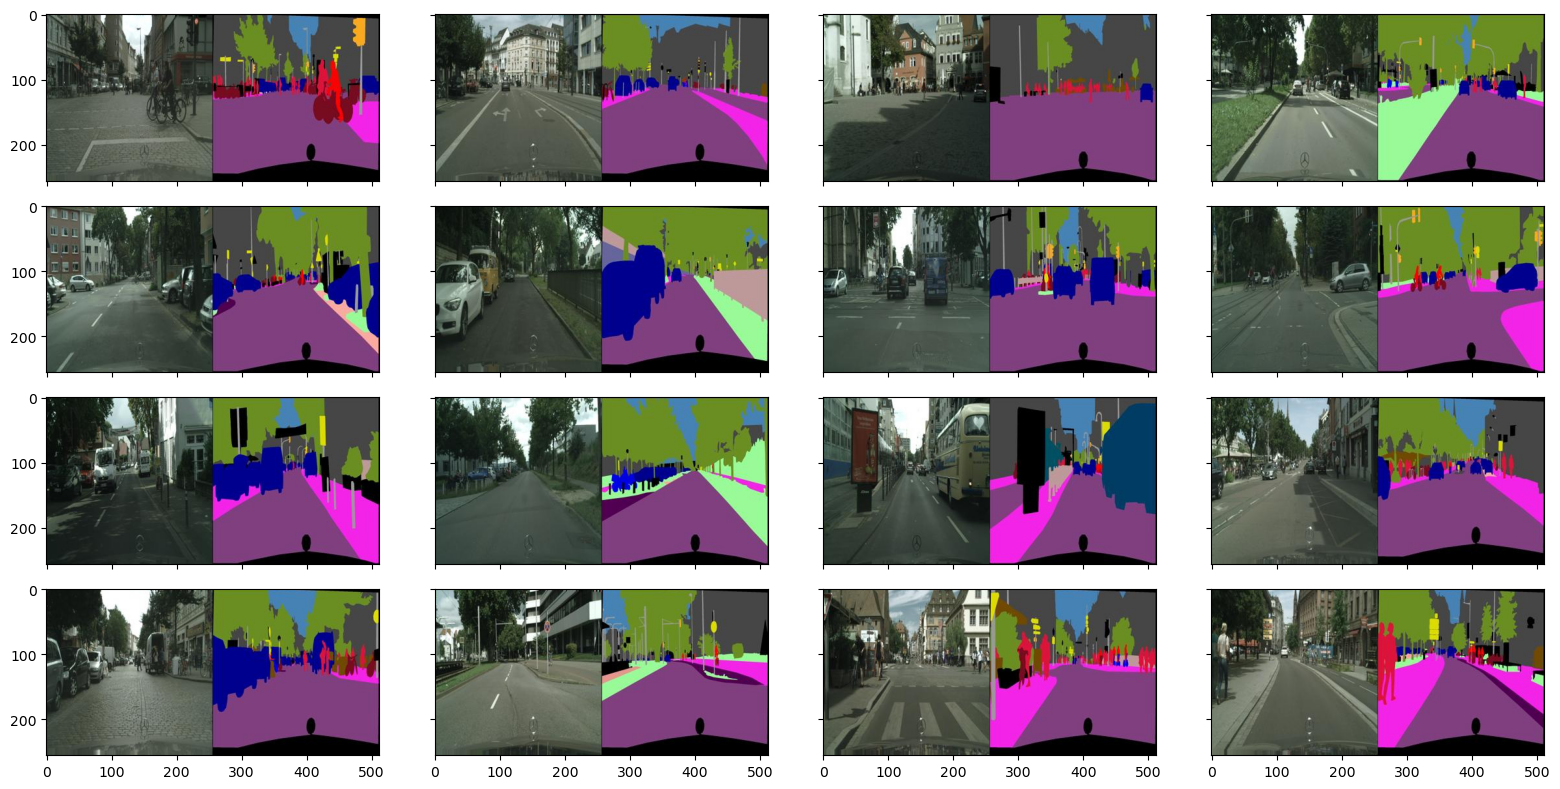

In [8]:
width = 4
height = 4
vis_batch_size = width * height

indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]

fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(16, 8))
for i in range(vis_batch_size):
    img = torchvision.io.read_image(training_images_paths[indexes[i]])

    # pytorch (c, h, w) -> (h, w, c) matplotlib 
    img = img.permute(1, 2, 0)
    
    y, x = i // width, i % width
    axs[y, x].imshow(img.numpy())
    
plt.tight_layout()

### Data preprocessing


In [9]:
# reference
# link : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

In [10]:
print(len(idx_to_color))

35


size of input :  (256, 256, 3)
size of mask raw :  (256, 256, 3)
size of classes :  (256, 256)


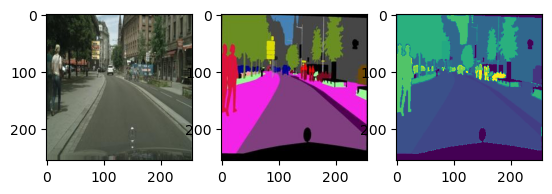

In [11]:
from typing import Tuple

name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)

# vectorize the operation of mapping the name to color for numpy (just a lookup in idx_to_color dictionary)
name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

def preprocess_image(path : str, sparse_mapping=True, downscale_factor=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Read the .jpeg image from *path*. Return the input image (256 x 256 x 3), mask (256 x 256 x 3) read from the jpeg 
        and conversion to categories or names (if sparse_mapping is true) representation (256 x 256 x (|categories| or |names|) )
    """
    # Read the image from path and dowscale if downscale_factor is not None.
    img = Image.open(path)
    width, height = img.size

    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor 
        img = img.resize(( width, height ))

    # then split the image into two images (in the middle of width) : input image and color mask (each represented by 3 channels)
    img = np.asarray(img)
    raw, mask = img[:, :width//2, :], img[:, width//2:, :]
    
    height, width, channels = mask.shape

    # compute then the sum of squared distances for each pixel to the colors (L2 between the color and pixel data) : 
    # the value which will be the minimal is the category name we will use for that pixel, and we will get it using argmin
    distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
    classes = np.argmin(distances, axis=1).reshape(height, width)

    # if we want to operate on names, map the categories to names
    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)
    
    return raw, mask, classes


x, mask_raw, classes = preprocess_image(training_images_paths[indexes[i]], sparse_mapping=False, downscale_factor=None)

# sanity checks and print the data
print("size of input : ", x.shape)
print("size of mask raw : ", mask_raw.shape)
print("size of classes : ", classes.shape)
plt.subplot(1, 3, 1)
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.imshow(mask_raw)
plt.subplot(1, 3, 3)
plt.imshow(classes)
plt.show()

### Load data and Pytorch dataset


In [12]:
train_images_to_use = -1

# for kaggle
downscale_factor=cfg.DOWNSCALE

X_train, Y_train = [], []
X_val, Y_val = [], []

for path in tqdm(training_images_paths[:]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

for path in tqdm(validation_images_paths):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
print(f"size of X_train : {len(X_train)} ; Y_train {len(Y_train)}")
print(f"size of X_val : {len(X_val)} ; Y_val {len(Y_val)}")

size of X_train : 2975 ; Y_train 2975
size of X_val : 500 ; Y_val 500


In [14]:
total_size_in_B = 0

for i in range(len(X_train)):
    total_size_in_B += X_train[i].element_size() * X_train[i].nelement()
    total_size_in_B += Y_train[i].element_size() * Y_train[i].nelement()

for i in range(len(X_val)):
    total_size_in_B += X_val[i].element_size() * X_val[i].nelement()
    total_size_in_B += Y_val[i].element_size() * Y_val[i].nelement()

print(f"The total size of data in RAM is {round(total_size_in_B / 1000 / 1000 / 1000, 3)} GB")

The total size of data in RAM is 0.911 GB


### Defining a class to access the data

In [15]:
# Pytorch Dataset
class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y
    
    
# just normalize the data
preprocess = transforms.Compose([
    transforms.Normalize(mean=cfg.MEAN, std=cfg.STD),
])

# create the Datasets
train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)

# create the dataloaders
train_dataloader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)

### Checking whether the data is loaded correctly

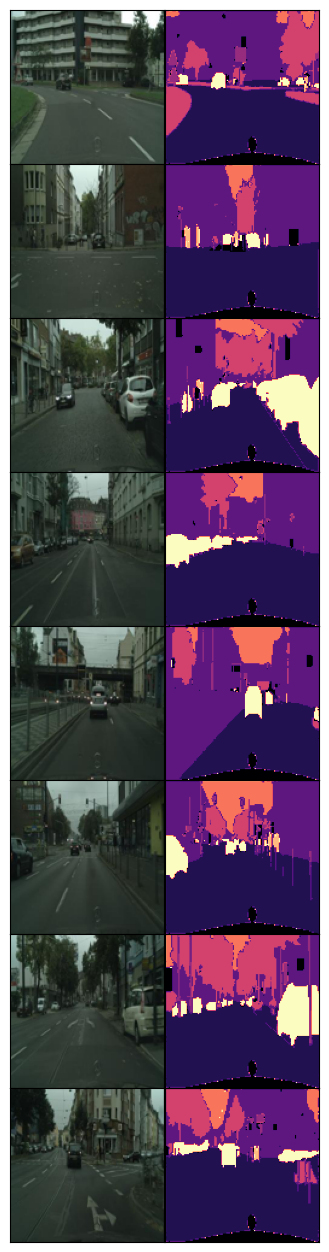

In [16]:
fig, axes = plt.subplots(cfg.BATCH_SIZE, 2, figsize=(4, 2.*cfg.BATCH_SIZE), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(cfg.BATCH_SIZE):
    img, mask = X_train[i], Y_train[i]  
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(img.permute(1,2, 0))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    axes[i, 1].imshow(mask, cmap='magma')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

### Data iterator

torch.Size([8, 3, 128, 128]) torch.Size([8, 128, 128])


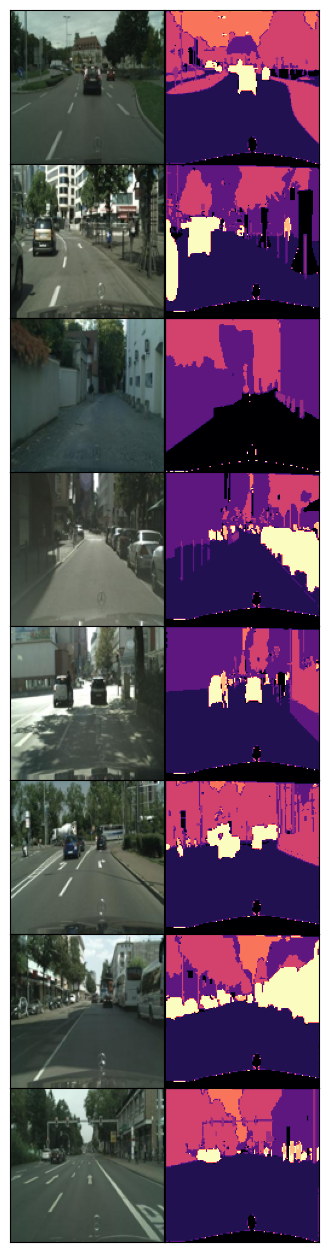

In [17]:
eval_batch_data = next(iter(val_dataloader))

def decode_image(img : torch.Tensor) -> torch.Tensor:
    return img * torch.Tensor(cfg.STD) + torch.Tensor(cfg.MEAN)

print(eval_batch_data[0].shape, eval_batch_data[1].shape)
batch_size = eval_batch_data[0].shape[0]
fig, axes = plt.subplots(batch_size, 2, figsize=(4, 2.*batch_size), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(batch_size):
    img, mask = eval_batch_data[0][i], eval_batch_data[1][i]  
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    axes[i, 1].imshow(mask, cmap='magma')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

### Loss Functions definition

In [18]:

def dice_coeff(inp : Tensor, tgt : Tensor, eps=cfg.EXTRA_LOSS_EPS):
    sum_dim = (-1, -2, -3)

    # calculation of intersection   
    inter = 2 *(inp * tgt).sum(dim=sum_dim)

    # calculate the sum of |inp| + |tgt|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    # calcaute the dice    
    dice = (inter + eps) / (sets_sum + eps)

    # average the dice of classwise
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, eps: float = cfg.EXTRA_LOSS_EPS):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), eps)

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - multiclass_dice_coeff(input, target)

def IoU_coeff(inp : Tensor, tgt : Tensor, eps = 1e-6):
    sum_dim = (-1, -2, -3)
    
    # Intersection term  |A ^ B|
    inter = (inp * tgt).sum(dim=sum_dim)
    
    # sum of |A| + |B|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    return (inter + eps) / (sets_sum - inter + eps)

def IoU_loss(inp : Tensor, tgt : Tensor):
    return 1 - IoU_coeff(inp.flatten(0,1), tgt.flatten(0,1))

## Evaluation functions

In [19]:
def evaluate_model(model, val_dataloader, epoch, epochs, criterion,
                   with_dice_loss=True, with_IoU_loss=False):
    global epoch_to_fig 
    val_loss = 0
    val_dice = 0
    val_IoU = 0
    with tqdm(val_dataloader, desc=f"Epoch {epoch}/{epochs} ; val Loss 0") as pbar:
        model.eval()
        examples_so_far = 0
        for i, batch in enumerate(val_dataloader):
            images, true_masks = batch[0], batch[1]
                
            images = images.to(device)
            true_masks = true_masks.to(device).long()                
                
            # predictions
            masks_pred = model(images)
            
            loss = criterion(masks_pred, true_masks)
            val_loss += loss.item() * images.shape[0]
            examples_so_far += images.shape[0]

            dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                             F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_dice_loss:
                loss += dice
            val_dice += images.shape[0] * (1.-dice.item())
                
            IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                           F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_IoU_loss:
                loss += IoU
            val_IoU += images.shape[0] * (1.-IoU.item())
            
            pbar.update(1)
                
            descr = f"Epoch {epoch}/{epochs} ; val Loss {round(val_loss / examples_so_far ,3)}, val IoU : {round(val_IoU / examples_so_far ,3)}, val Dice : {round(val_dice / examples_so_far ,3)}"               
            pbar.set_description(descr)

    eval_summary = {}
    eval_summary["validation_loss"] = val_loss / examples_so_far
    eval_summary["validation_DICE_coefficient"] = val_dice / examples_so_far
    eval_summary["validation_IoU_coefficient"] = val_IoU / examples_so_far

    return eval_summary

## Training functions

In [20]:
def train_model(model, device, train_dataloader,
                val_dataloader, epochs=10, lr=1e-4, update_pb_every_batch = 1,
                with_dice_loss=True, with_IoU_loss=False):
    global global_step
    
    # setup the optimizer, loss, learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    
    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

    returned_data = []

    for epoch in range(1, epochs + 1):
        
        training_loss = 0
        training_dice = 0
        training_IoU = 0
        with tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss,3)}") as pbar:
            model.train()
            optimizer.zero_grad()
            examples_so_far = 0
            for i,batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                images, true_masks = batch[0], batch[1]
                
                images = images.to(device)
                true_masks = true_masks.to(device).long()
                                
                masks_pred = model(images)
                
                loss = criterion(masks_pred, true_masks)
                if with_dice_loss:
                    dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += dice
                    training_dice += images.shape[0] * (1.-dice.item())
                
                if with_IoU_loss:
                    IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += IoU
                    training_IoU += images.shape[0] * (1.-IoU.item())
                
                # Backward and optimize
                #loss.backward()
                accelerator.backward(loss)
                optimizer.step()
                
                global_step += 1
                training_loss += images.shape[0] * loss.item()
                examples_so_far += images.shape[0]

                pbar.update(1)
                if i % update_pb_every_batch == 0:
                    descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}"        
                    if with_dice_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg DICE : {round(training_dice / examples_so_far ,3)}"   
                    elif with_IoU_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg IoU : {round(training_IoU / examples_so_far ,3)}"
                    
                    pbar.set_description(descr)
        
        epoch_summary = {}
        epoch_summary["training_loss"] = training_loss / examples_so_far
        if with_dice_loss:
            epoch_summary["training_DICE_coefficient"] = training_dice / examples_so_far
        if with_IoU_loss:
            epoch_summary["training_IoU_coefficient"] = training_IoU / examples_so_far


        val_summary = evaluate_model(model, val_dataloader, epoch, epochs, criterion, with_dice_loss=with_dice_loss, with_IoU_loss=with_IoU_loss)
        epoch_summary = {**epoch_summary, **val_summary}
        returned_data.append(epoch_summary)

    return returned_data

### Inference Functions

In [21]:
def show_inference(batch, predictions):

    batch_size = batch[0].shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(6, 2.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.05, wspace=0)

    for i in range(batch_size):
        img, mask = batch[0][i], batch[1][i]  

        axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        if i == 0:
            axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(mask, cmap='magma')
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        if i == 0:
            axes[i, 1].set_title("True Mask")

        predicted = predictions[i]
        predicted = predicted.permute(1, 2, 0)
        predicted = torch.argmax(predicted, dim=2)

        axes[i, 2].imshow(predicted.cpu(), cmap='magma')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
        if i == 0:
            axes[i, 2].set_title("Predicted Mask")



## plot the losses/coefficients

In [22]:
def plot_losses_coeffs(training_val_summary):

    if cfg.SNS_STYLE is not None:
        sns.set(style=cfg.SNS_STYLE)

    training = defaultdict(list)
    validation = defaultdict(list)

    m = 0

    for epoch_summary in training_val_summary:
        keys = list(epoch_summary.keys())

        training_keys = [k for k in keys if k.startswith("training")]
        for k in training_keys:
            training[k[len("training")+1:]].append(epoch_summary[k])

        val_keys = [k for k in keys if k.startswith("validation")]
        for k in val_keys:
            validation[k[len("validation")+1:]].append(epoch_summary[k])

    fig, axes = plt.subplots(len(validation.keys()), 1, figsize=(10, 10), sharex=True)

    for i,k in enumerate(validation.keys()):

        if k in training:
            axes[i].plot(training[k], marker='o', linestyle='--', label="training", linewidth=3)


        if validation[k][-1] > validation[k][0]:
            best_idx = np.argmax(validation[k])
        else:
            best_idx = np.argmin(validation[k])
        
        best = validation[k][best_idx]

        axes[i].set_title(f"{k} (validation best : {round(best, 4)})", fontsize=14, fontweight="bold")
        axes[i].plot(validation[k], label="validation", marker='o', linestyle='--', linewidth=3)

        axes[i].plot([0, best_idx], [best, best], linewidth=2, linestyle="--", color='black', alpha=0.5)
        m = max(m, len(validation[k]))
        axes[i].legend()

    axes[-1].set_xticks(list(range(0, m)))
    axes[-1].set_xticklabels(list(range(1, m + 1)))
    sns.set(style="white")

# Unet

## Architecture

In [23]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.cn1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.activ1 = nn.ReLU(inplace=True)
        self.cn2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activ2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.cn1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.cn2(x)
        x = self.bn2(x)
        return self.activ2(x)

class DownScale(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlock(in_channels, out_channels)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.block(x)
        return x
 

class UpScale(nn.Module): 
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = ConvBlock(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)
        self.down3 = DownScale(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = DownScale(8*start, 16*start // factor)
        
        self.up1 = UpScale(16*start, 8*start // factor, bilinear)
        self.up2 = UpScale(8*start, 4*start // factor, bilinear)
        self.up3 = UpScale(4*start, 2*start // factor, bilinear)
        self.up4 = UpScale(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    

number_of_classes = len(set(name_to_category.values()))
summary(Unet(3, number_of_classes), input_data=eval_batch_data[0])

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [8, 8, 128, 128]          --
├─ConvBlock: 1-1                         [8, 32, 128, 128]         --
│    └─Conv2d: 2-1                       [8, 32, 128, 128]         864
│    └─BatchNorm2d: 2-2                  [8, 32, 128, 128]         64
│    └─ReLU: 2-3                         [8, 32, 128, 128]         --
│    └─Conv2d: 2-4                       [8, 32, 128, 128]         9,216
│    └─BatchNorm2d: 2-5                  [8, 32, 128, 128]         64
│    └─ReLU: 2-6                         [8, 32, 128, 128]         --
├─DownScale: 1-2                         [8, 64, 64, 64]           --
│    └─MaxPool2d: 2-7                    [8, 32, 64, 64]           --
│    └─ConvBlock: 2-8                    [8, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [8, 64, 64, 64]           18,432
│    │    └─BatchNorm2d: 3-2             [8, 64, 64, 64]           128
│    │

## Training

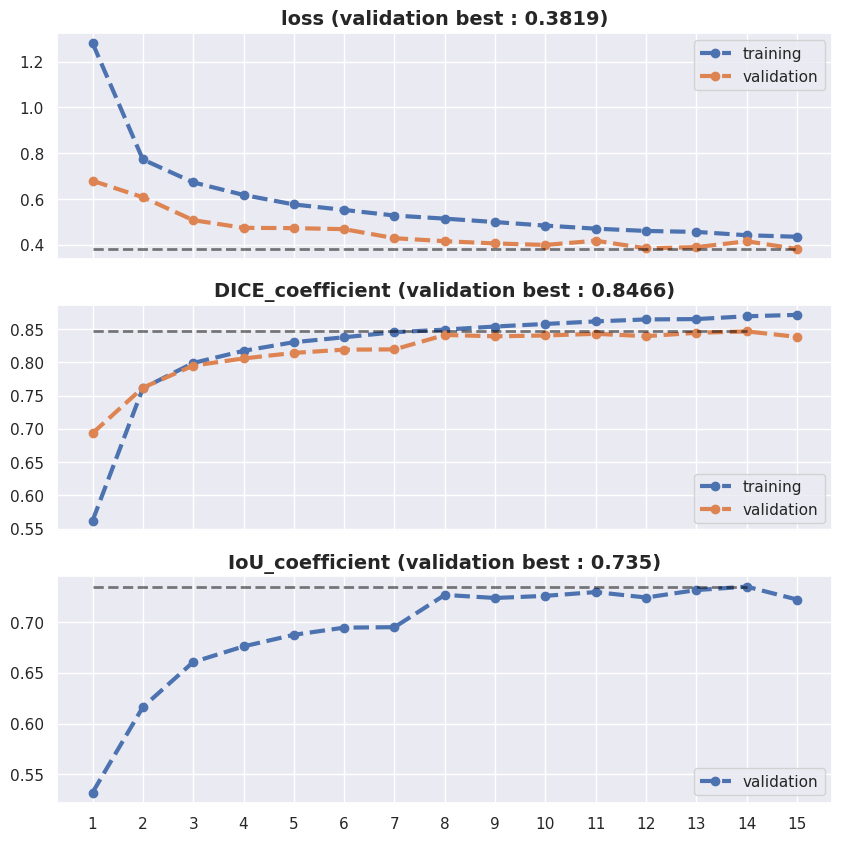

In [34]:
device = "cuda"
model = Unet(3, number_of_classes)
model = model.to(device)

Unet_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=cfg.SINGLE_NETWORK_TRAINING_EPOCHS, update_pb_every_batch=10)

clear_output(True)
plot_losses_coeffs(Unet_training_val_summary)


### Saving the trained model

In [35]:
torch.save(model.state_dict(), 'unet_model_weights_final.pth')

### Loading the saved model

In [26]:
device = "cuda"
model = Unet(3, number_of_classes)
model.load_state_dict(torch.load('unet_model_weights_final.pth'))
model = model.to(device)

### Inference (Show results)

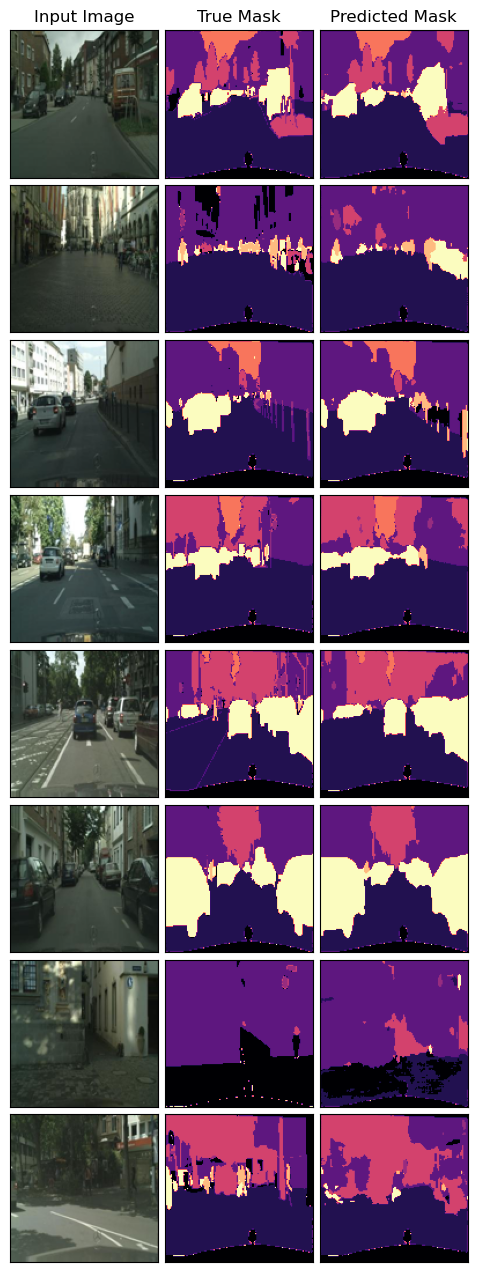

In [27]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)

# DeepLabV3

## Architecture

In [29]:
from torchvision.models.segmentation import deeplabv3_resnet50

class DeepLabV3Wrapper(nn.Module):
    def __init__(self, num_classes):
        # use encoder to pass pretrained encoder
        super().__init__()
        self.model = deeplabv3_resnet50(num_classes=num_classes)

    def forward(self, image):
        return self.model(image)['out']
        
number_of_classes = len(set(name_to_category.values()))
model = DeepLabV3Wrapper(number_of_classes)
summary(model, input_data=batch[0])

Layer (type:depth-idx)                                  Output Shape              Param #
DeepLabV3Wrapper                                        [8, 8, 128, 128]          --
├─DeepLabV3: 1-1                                        [8, 8, 128, 128]          --
│    └─IntermediateLayerGetter: 2-1                     [8, 2048, 16, 16]         --
│    │    └─Conv2d: 3-1                                 [8, 64, 64, 64]           9,408
│    │    └─BatchNorm2d: 3-2                            [8, 64, 64, 64]           128
│    │    └─ReLU: 3-3                                   [8, 64, 64, 64]           --
│    │    └─MaxPool2d: 3-4                              [8, 64, 32, 32]           --
│    │    └─Sequential: 3-5                             [8, 256, 32, 32]          215,808
│    │    └─Sequential: 3-6                             [8, 512, 16, 16]          1,219,584
│    │    └─Sequential: 3-7                             [8, 1024, 16, 16]         7,098,368
│    │    └─Sequential: 3-8          

## Training

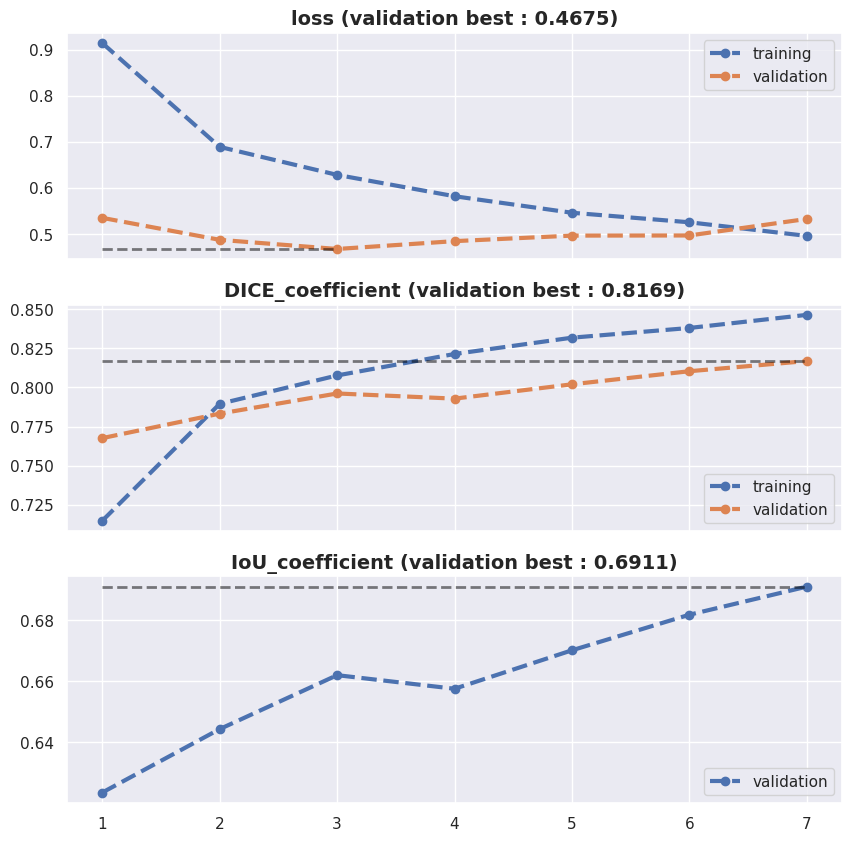

In [29]:
device = "cuda"
model = DeepLabV3Wrapper(number_of_classes)
model = model.to(device)

deeplabv3_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=1e-4, epochs=7, update_pb_every_batch=10)

clear_output(wait=True)
plot_losses_coeffs(deeplabv3_training_val_summary)

### Saving the trained model

In [ ]:
torch.save(model.state_dict(), 'deep_lab_v3_weights.pth')

### Loading the saved model

In [30]:
device = "cuda"
model = DeepLabV3Wrapper(number_of_classes)
model.load_state_dict(torch.load('deep_lab_v3_weights.pth'))
model = model.to(device)

## Inference for Deep Lab v3

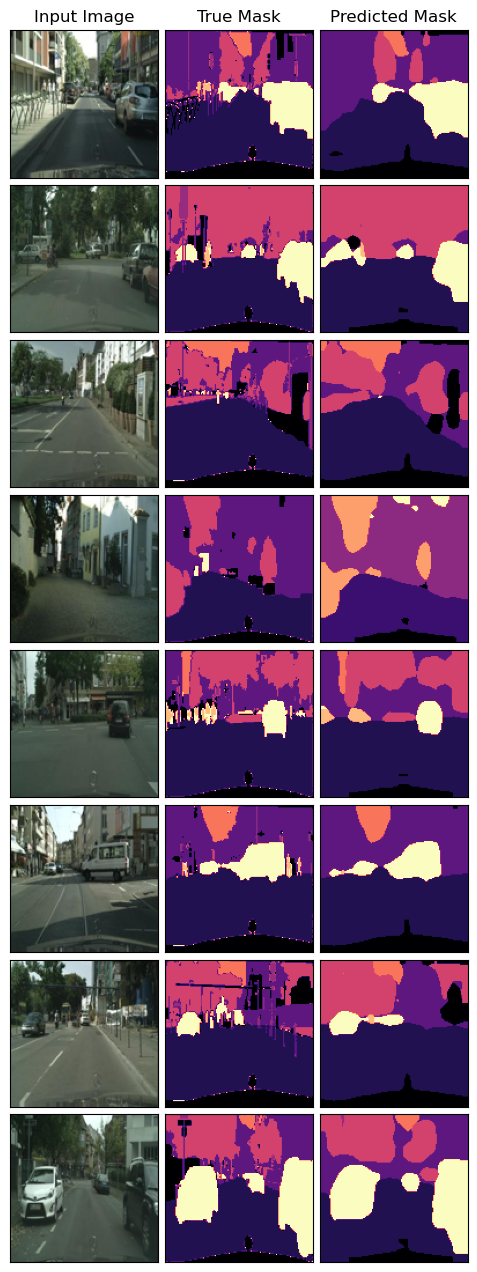

In [31]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)